In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Clone git repository
!git clone https://github.com/lukabibic/Deepspeech2-projekt.git

Cloning into 'Deepspeech2-projekt'...
remote: Enumerating objects: 10093, done.
remote: Counting objects: 100% (838/838), done.
remote: Compressing objects: 100% (835/835), done.
remote: Total 10093 (delta 2), reused 659 (delta 1), pack-reused 9255
Receiving objects: 100% (10093/10093), 863.85 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (88/88), done.
Updating files: 100% (10739/10739), done.


In [4]:
%cd Deepspeech2-projekt/

/content/Deepspeech2-projekt


In [5]:
!python preprocess.py

ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
ws_ftp.loghas no .wav extension! Deleted!
m02030402901.wav has no transcription .txt file! Deleted!
m02030402902.wav has no transcription .txt file! Deleted!
m02030402903.wav has no transcription .txt file! Deleted!
m02030402904.wav has no transcription .txt file! Deleted!
m02030402905.wav has no transcription .txt file! Deleted!
m02030402906.wav has no transcription .txt file! Deleted!
m02030402907.wav has no transcription .txt file! Deleted!
m02030402908.wav has no transcription .txt file! Deleted!
m02030402909.wav has no transcription .txt file! Deleted!
m02030402910.wav

In [6]:
!python dataset.py

Dataset (.csv) is ready!


In [7]:
!python resample.py

Resampling .wav files to 16khz in progress. It may take a few minutes...
Resampling of .wav files is done!


In [8]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00


In [28]:
#Setup
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import os

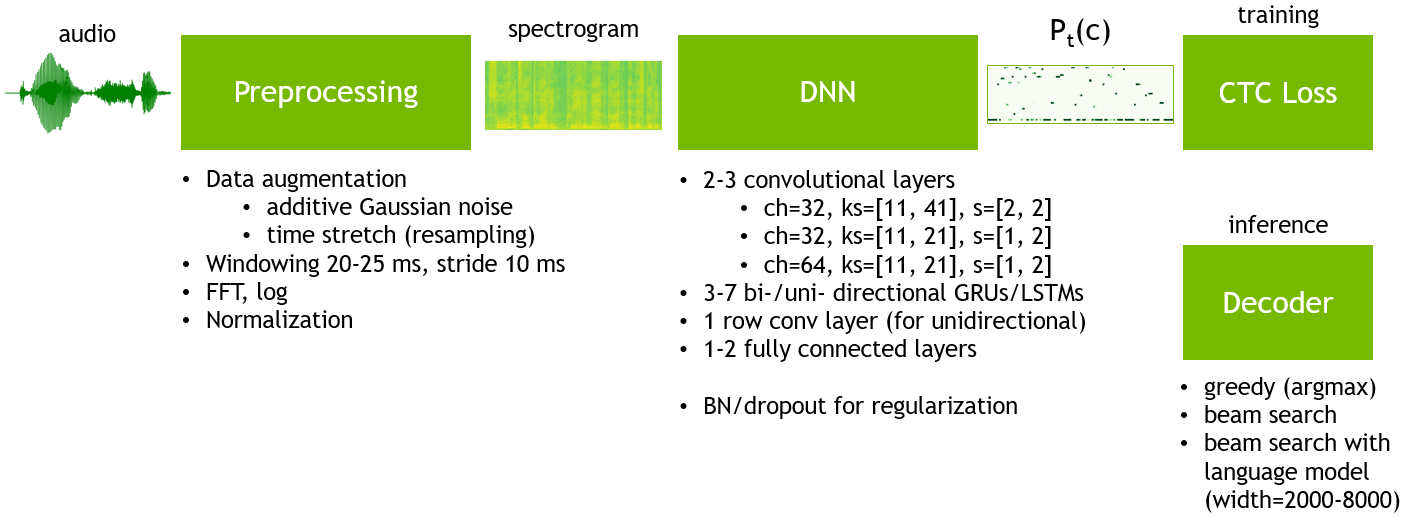

In [10]:
#Deepspeech2 Architecture
from IPython.display import Image
Image("deepspeech2_arch.png", width=800, height=400)

In [29]:
#Load dataset
wavs_path = os.path.join(os.getcwd(), "resampled/")
audio_transcription_mapping = os.path.join(os.getcwd(), "dataset.csv")


# Read metadata file and parse it
mapping_df = pd.read_csv(audio_transcription_mapping, sep="|", header=0, quoting=3)
mapping_df.columns = ["filename", "transcription"]
mapping_df = mapping_df[["filename", "transcription"]]
mapping_df = mapping_df.sample(frac=1).reset_index(drop=True)
mapping_df.head(3)

,filename,transcription
0,m08010702208,more umjereno valovito na otvorenom ponegdje v...
1,m11220502401,izvje{taj pomorskog meteorolo{kog centra split...
2,m08110502104,najvi{a temperatura od dvadeset do dvadeset pe...


In [30]:
#Split data
split = int(len(mapping_df) * 0.90)
df_train = mapping_df[:split]
df_val = mapping_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the test set: {len(df_val)}")

Size of the training set: 4729
Size of the test set: 526


In [13]:
#Preprocessing
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnoprstuvz{}<>#~`^ "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'z', '{', '}', '<', '>', '#', '~', '`', '^', ' '] (size =32)


In [14]:
#Transformation
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [15]:
#Creating Dataset objects
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["filename"]), list(df_train["transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["filename"]), list(df_val["transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

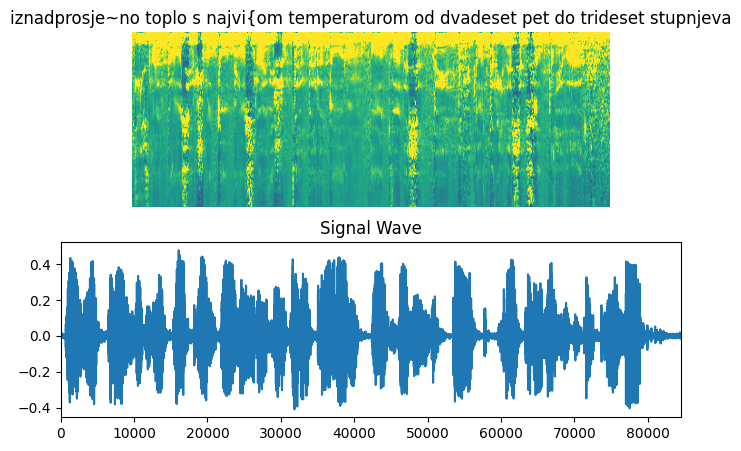

In [16]:
#Visualize the data
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["filename"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [17]:
#CTC Loss function
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [18]:
#DeepSpeech2 Model
def build_model(input_dim, output_dim, rnn_layers=7, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
     # Convolution layer 3
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_3",
    )(x)
    x = layers.BatchNormalization(name="conv_3_bn")(x)
    x = layers.ReLU(name="conv_3_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [19]:
#Training and Evaluating
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [20]:
#Start training
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/50
1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : vremenski izgledi do sredine slijede^ega tjedna <uzdah> prete`no sun~ano osobito na jadranu <uzdah>
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : a u unutra{njosti susnje`ica i snijeg te mjestimice ki{a koja se smrzava na tlu <uzdah>
Prediction: 
----------------------------------------------------------------------------------------------------
148/148 [==============================] - 571s 4s/step - loss: 328.0419 - val_loss: 1289.4641
Epoch 2/50
1/1 [==============================] - 0s 142ms/step
----------------------------------------------------------------------------------------------------
Word Error Ra

In [22]:
new_epochs = 20  # Additional number of epochs you want to train

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs + new_epochs,  # Update the total number of epochs
    initial_epoch=epochs,  # Set the initial epoch to the last epoch of the previous training
    callbacks=[validation_callback],
)

Epoch 51/70
1/1 [==============================] - 0s 145ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1923
----------------------------------------------------------------------------------------------------
Target    : biometeorolo{ka prognoza za sutra <uzdah>
Prediction: biometeorolo{ka prognoza za sutra <uzdah>
----------------------------------------------------------------------------------------------------
Target    : more malo na otvorenom dijelu sjevernog a potkraj dana i na srednjem jadranu i umjereno valovito malo toplije
Prediction: more malo na otvorenom dijelu sjevernog a potkraj dana i na srednjem jadranu i umjereno valovito a olje
----------------------------------------------------------------------------------------------------
148/148 [==============================] - 75s 503ms/step - loss: 30.1119 - val_loss: 69.1603
Epoch 52/70
1/1 [==============================] - 0s 143ms/step
--

In [23]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 143ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1646
----------------------------------------------------------------------------------------------------
Target    : more jedan do dva u no^i na sjevernom jadranu tri do ~etiri <uzdah> vidljivost deset do dvadeset kilometara mjestimice zbog sumaglice oko ~etiri kilometra <uzdah>
Prediction: mora jedan do dva u no^i na sjevernom jadranu tri do ~etiri <uzdah> vidljivost deset do dvadeset kilometara mjestimice tog sumaglice oko ~etiri kilometara uzdah>
----------------------------------------------------------------------------------------------------
Target    : temperatura od petnaest do dvadeset stupnjeva
Prediction: temperatura od petnaest do dvadeset stupnjeva
----------------------------------------------------------------------------------------------------
Target    : o vremenu danas i sutra dunja drvar
Predic

In [24]:
model.save("deepspeech2_model_tf.h5")

In [26]:
pt_model = tf.keras.models.load_model("/content/Deepspeech2-projekt/deepspeech2_model_tf.h5", compile=False)

In [27]:
# Let's check results on more validation samples on save pretrained model
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = pt_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1646
----------------------------------------------------------------------------------------------------
Target    : pote{ko^e uzrokovane vremenom mogli bi imati i kroni~ni bolesnici <uzdah>
Prediction: pote{ko^e uzrokovane vremenom a mogli bi imati kroni~ni bolesnici <uzdah>
----------------------------------------------------------------------------------------------------
Target    : na jadranu slabo do umjereno jugo i <jugozapadak> zapadnjak u okretanju na sjeverozapadnjak
Prediction: na jadranu slabo do umjereno jugo i jugozapada zapadnjak u okretanju na sjeverozapadnjak
----------------------------------------------------------------------------------------------------
Target    : do kraja dana slabo jugo
Prediction: do kraja dana slabo jugo
-----------------------------------------------------------------------